In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Preprocessing

## Dataset creation

In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [4]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

## Fluorprobe exploration

In [5]:
fp_df['depth_discrete'] = fp_df['depth'].apply(lambda x: min(biomass_by_week_year_group['Depth'], key=lambda y: abs(y - x)))

## Splitting to test temporarily & Extracting probe's test data

In [6]:
biomass_test = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] >= 3)]
biomass_train = biomass_by_week_year_group[~biomass_by_week_year_group.index.isin(biomass_test.index)]

fp_test = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] >= 3)]
fp_train = fp_df[~fp_df.index.isin(fp_test.index)]

merged_train = merge_fp_biomass_df(fp_train, biomass_train, is_train=True) # Merging fully
merged_test = merge_fp_biomass_df(fp_test, biomass_test, is_train=False) # Merging only closest records by depth

In [7]:
merged_train = merged_train.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_test_df = merged_test[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_test = merged_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

In [8]:
biomass_estimation(merged_train)

# EDA and Cleaning

In [9]:
merged_train.shape

(56557, 18)

In [10]:
merged_train = merged_train[merged_train['sum_biomass_ug_ml'] >= 0]

In [11]:
merged_train.shape

(54469, 18)

In [12]:
merged_train.loc[merged_train['Depth'] >= 21, 'Depth'] = 21

In [13]:
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub', 'sum_biomass_ug_ml']

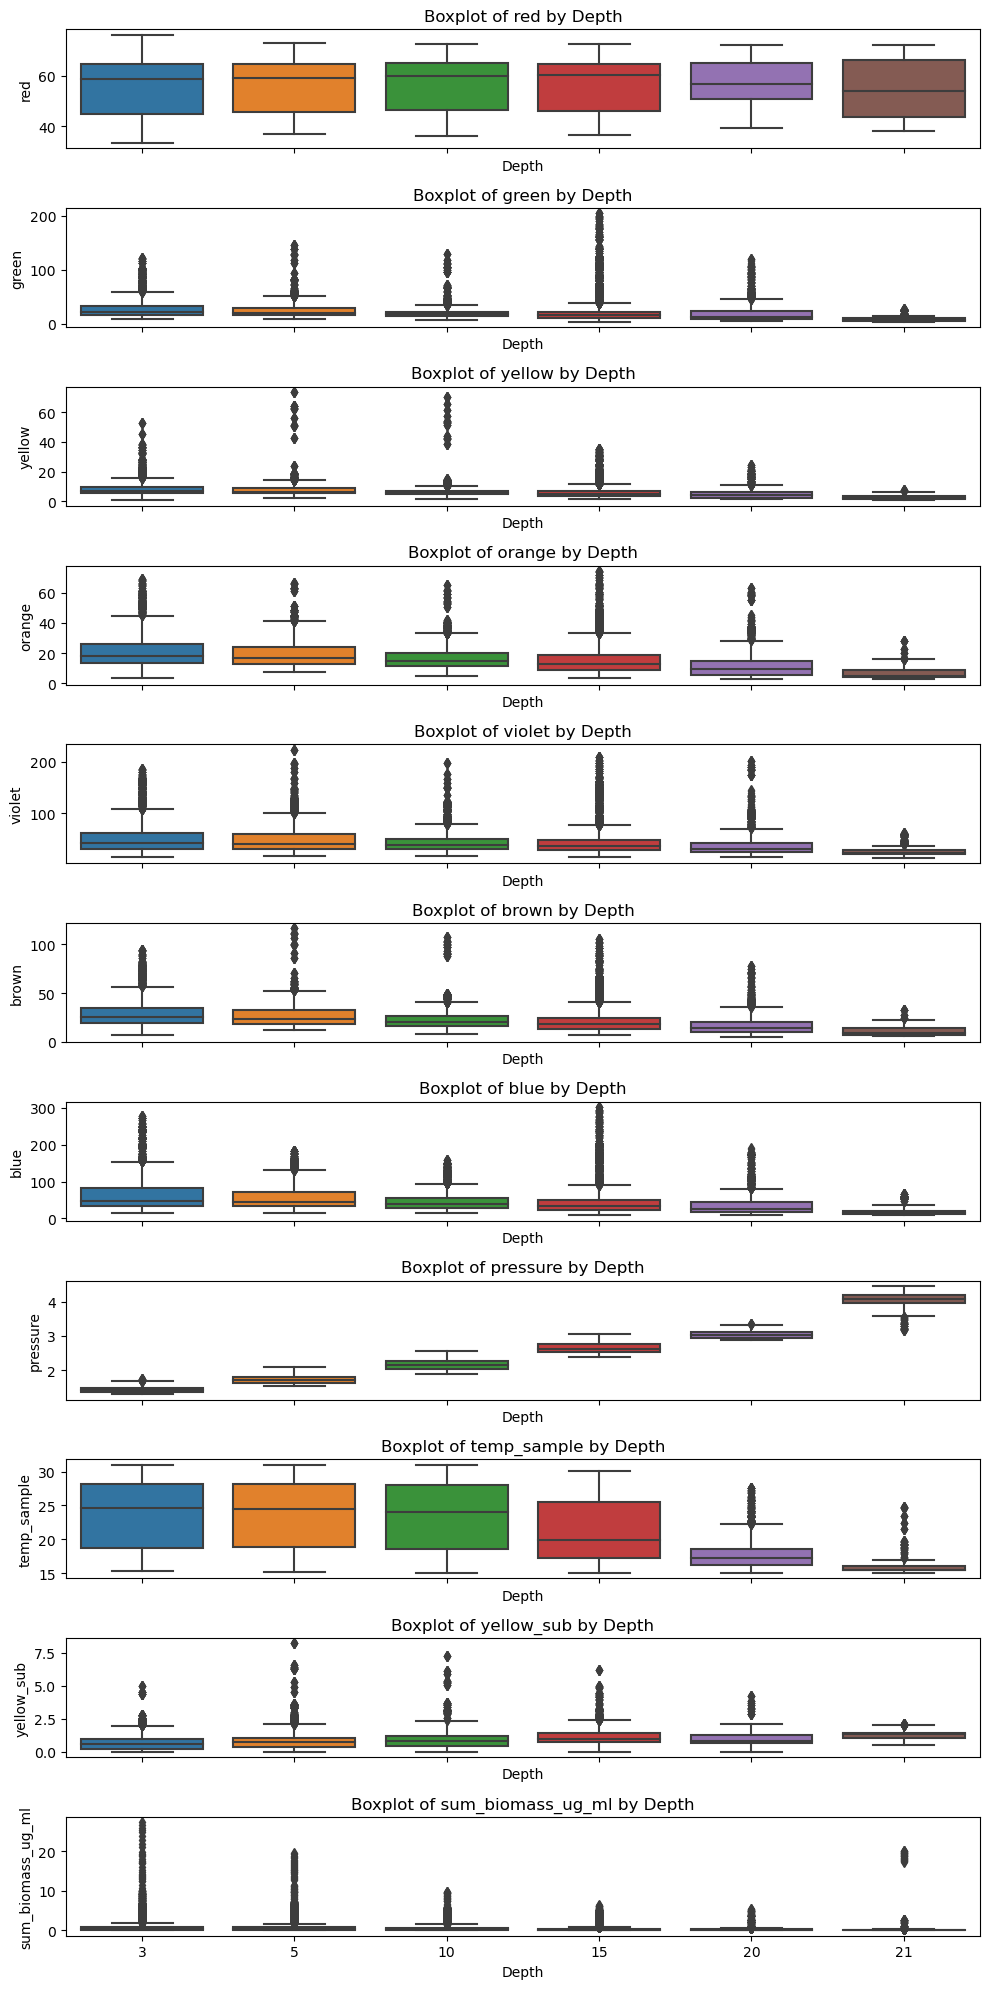

In [14]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

In [15]:
signals.remove('sum_biomass_ug_ml')
signals.remove('pressure')
signals.remove('temp_sample')
boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 120},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 60},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 80},
    'blue': {'lower_bound': 0, 'upper_bound': 220},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 7}
}

filter_signals_by_boundaries(merged_train, signals, boundaries)

In [16]:
merged_train.shape

(53505, 18)

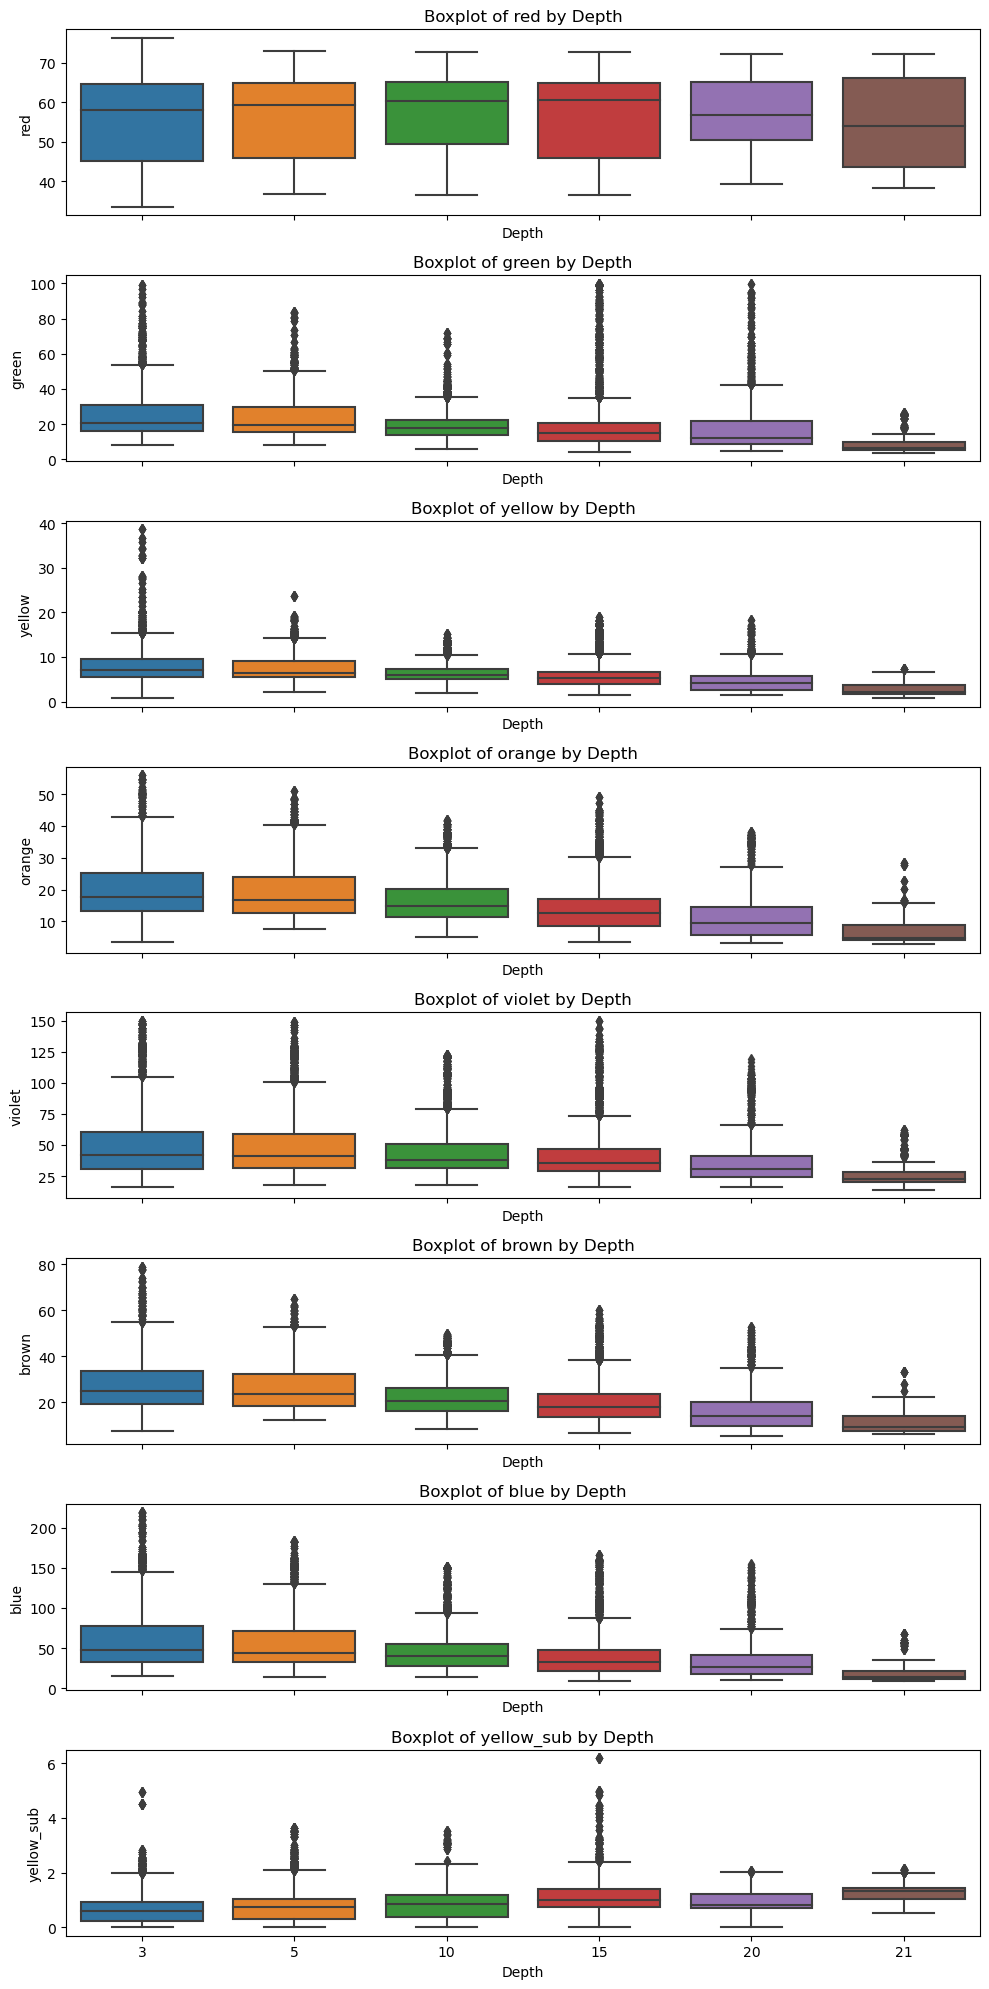

In [17]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

## Log Transforming Biomass Values

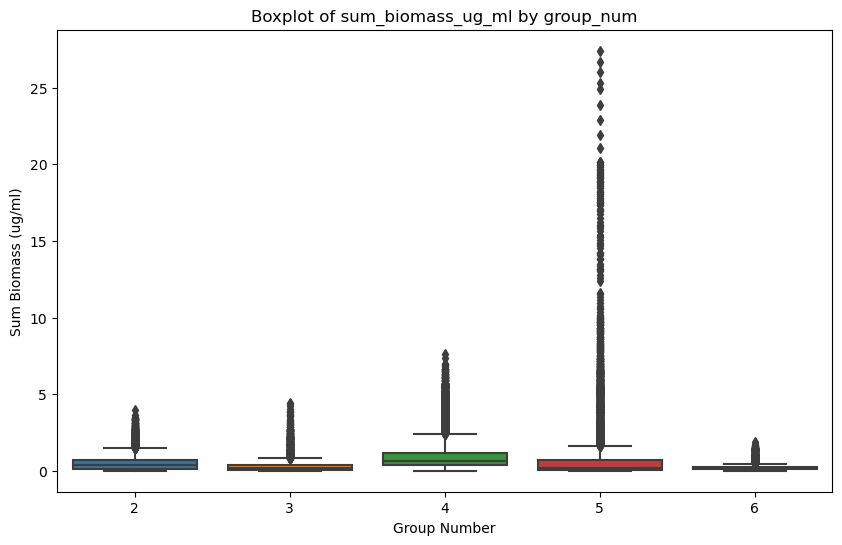

In [55]:
boxplot_biomass_by_group(merged_train)

In [71]:
merged_train = merged_train[merged_train['sum_biomass_ug_ml'] < 2]

In [84]:
merged_train.drop(merged_train[(merged_train['group_num'] == 3) & (merged_train['sum_biomass_ug_ml'] > 1)].index, inplace=True)

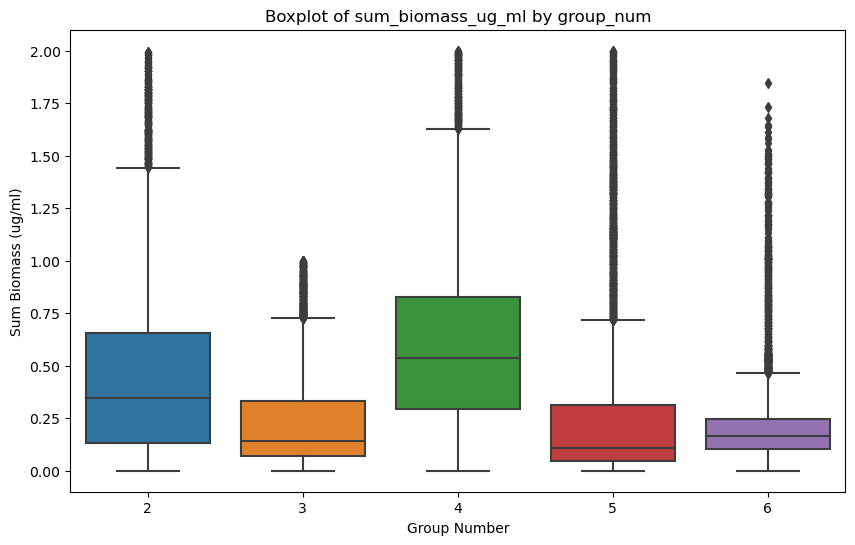

In [85]:
boxplot_biomass_by_group(merged_train)

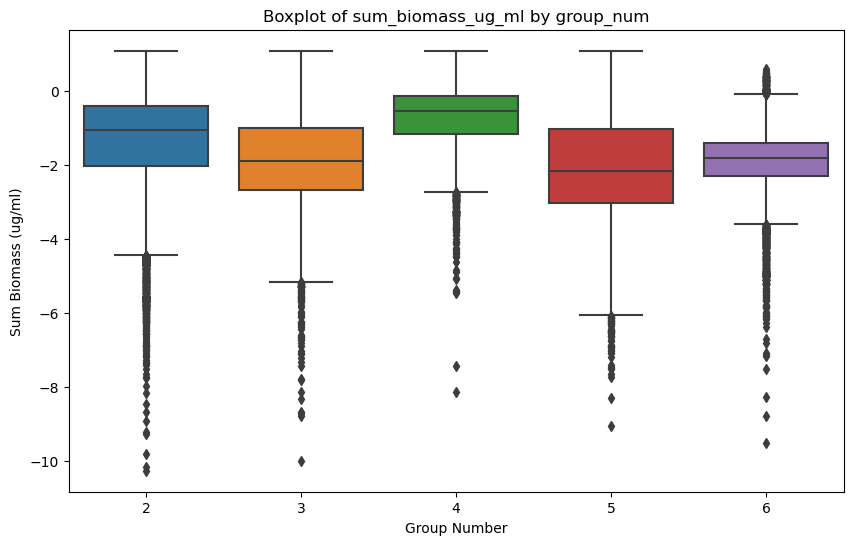

In [66]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.log)
boxplot_biomass_by_group(merged_train)

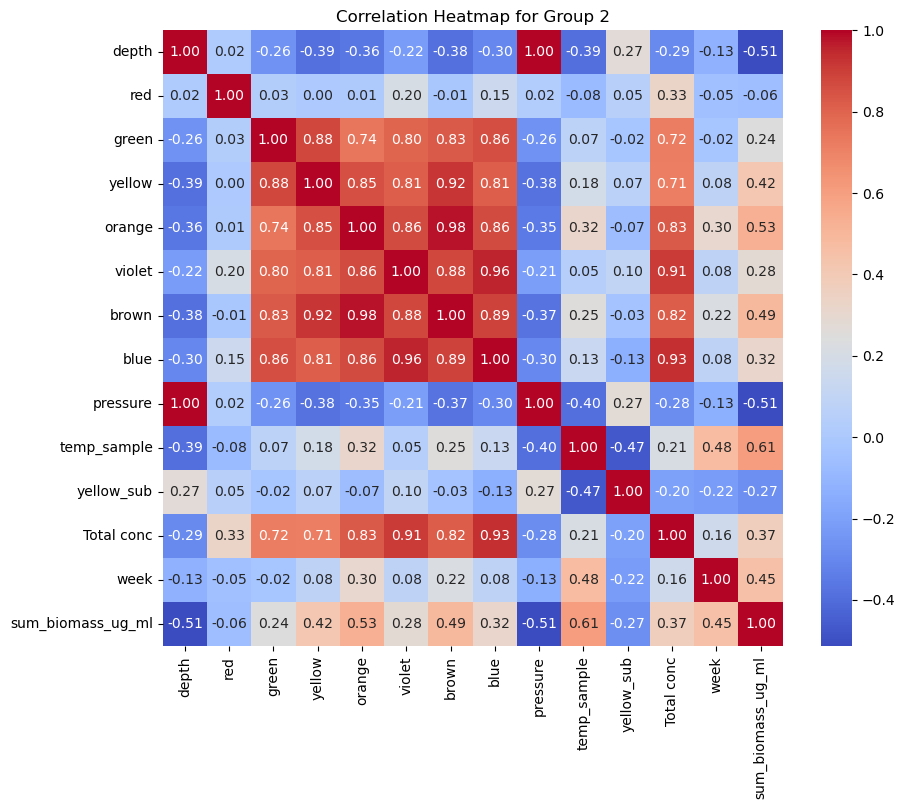

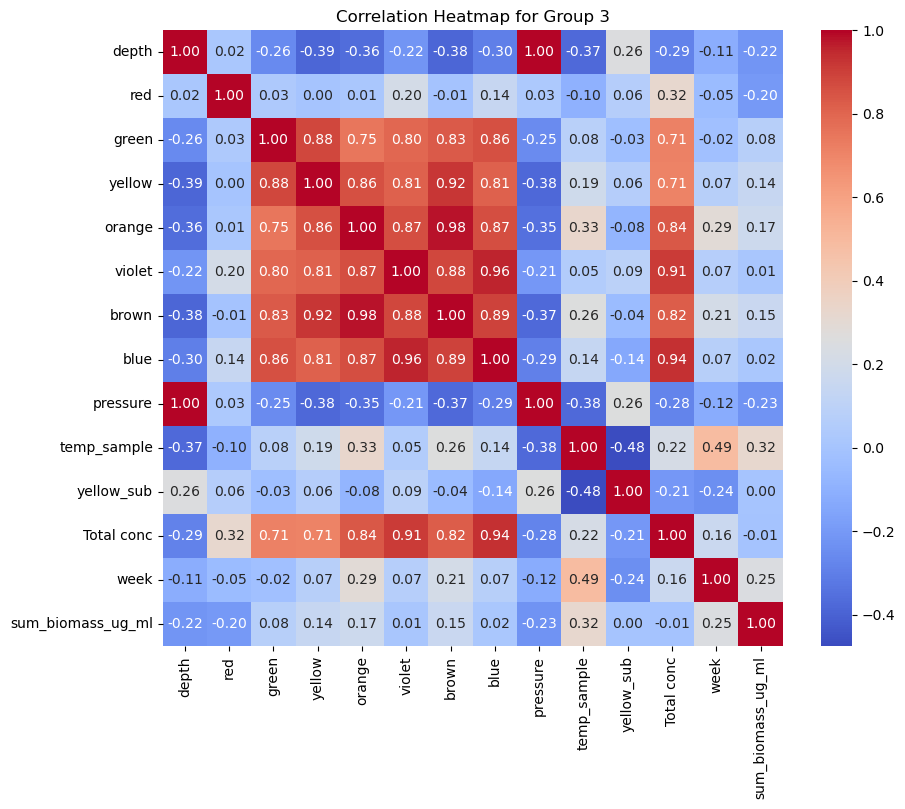

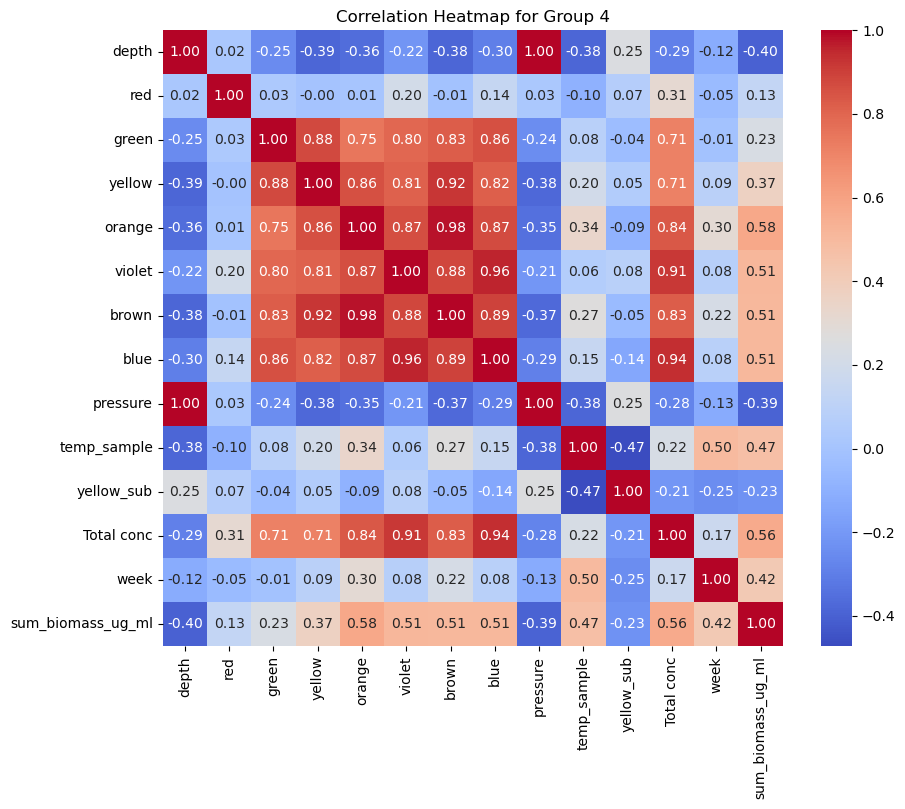

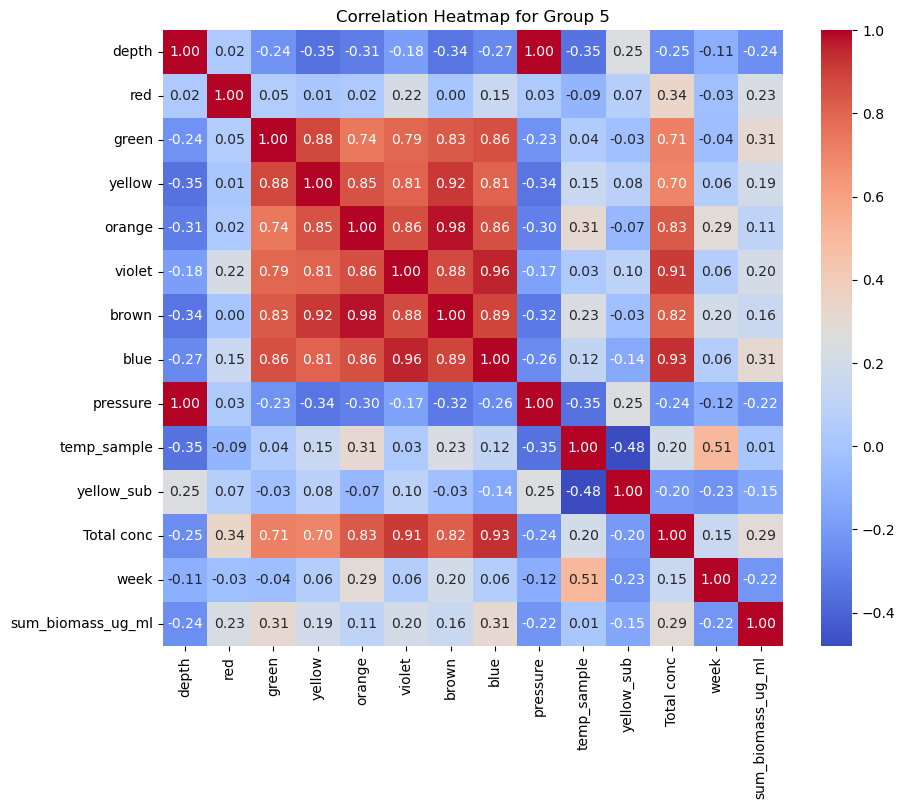

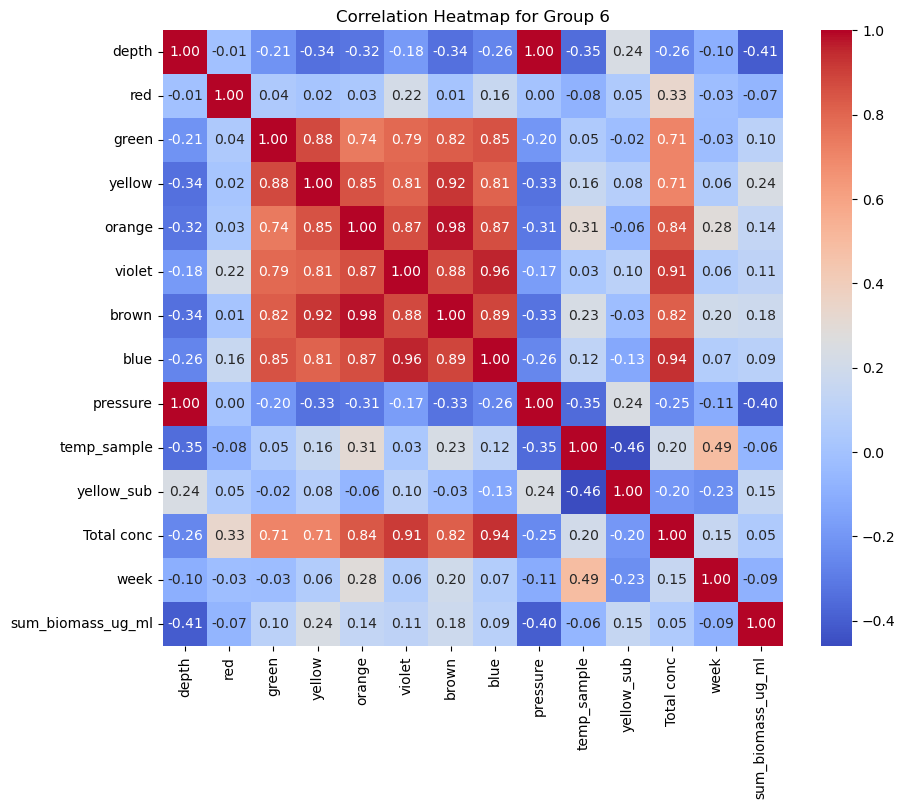

In [19]:
correlation_per_group(merged_train)

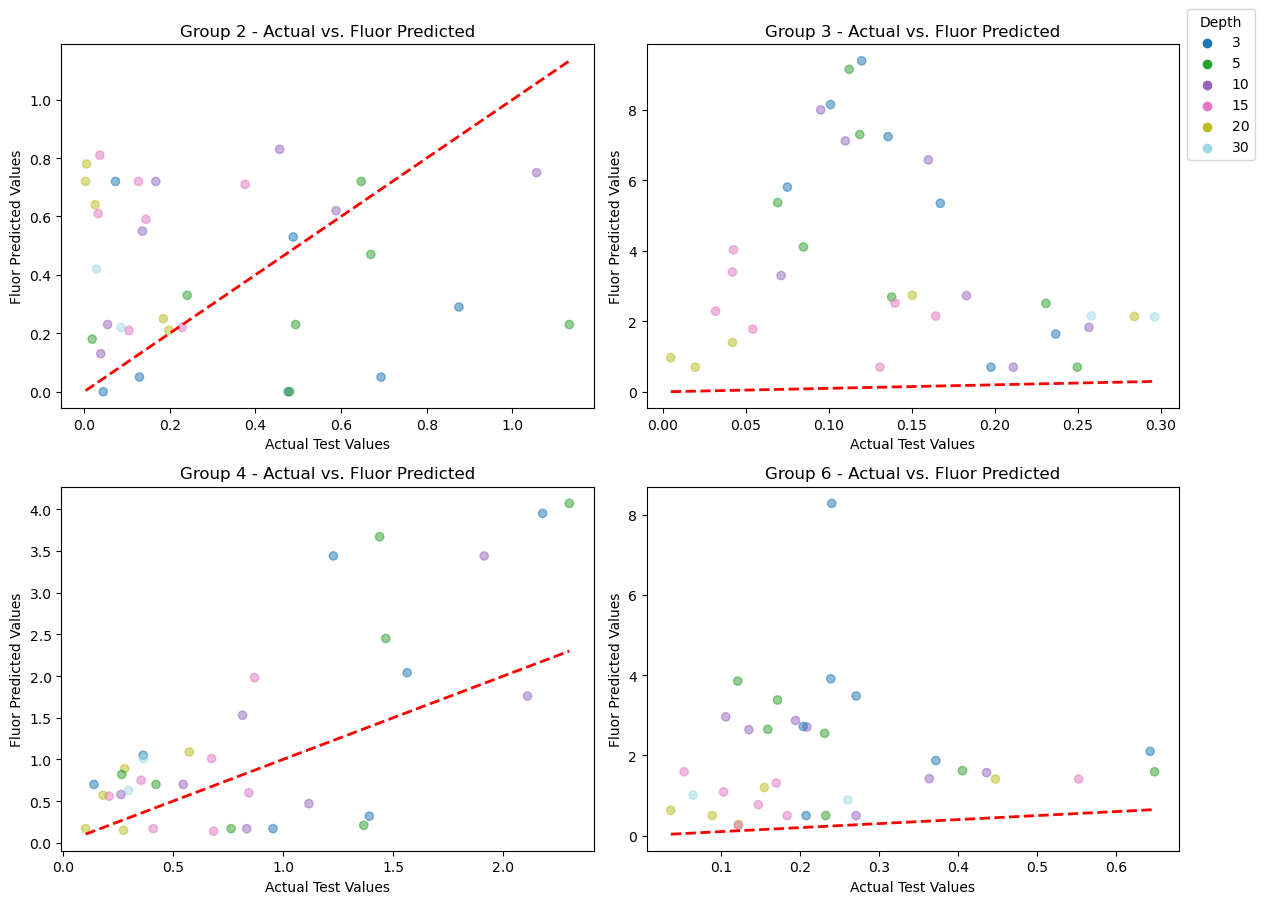

In [28]:
plot_fluorprobe_prediction(fluor_test_df, fluor_groups_map)

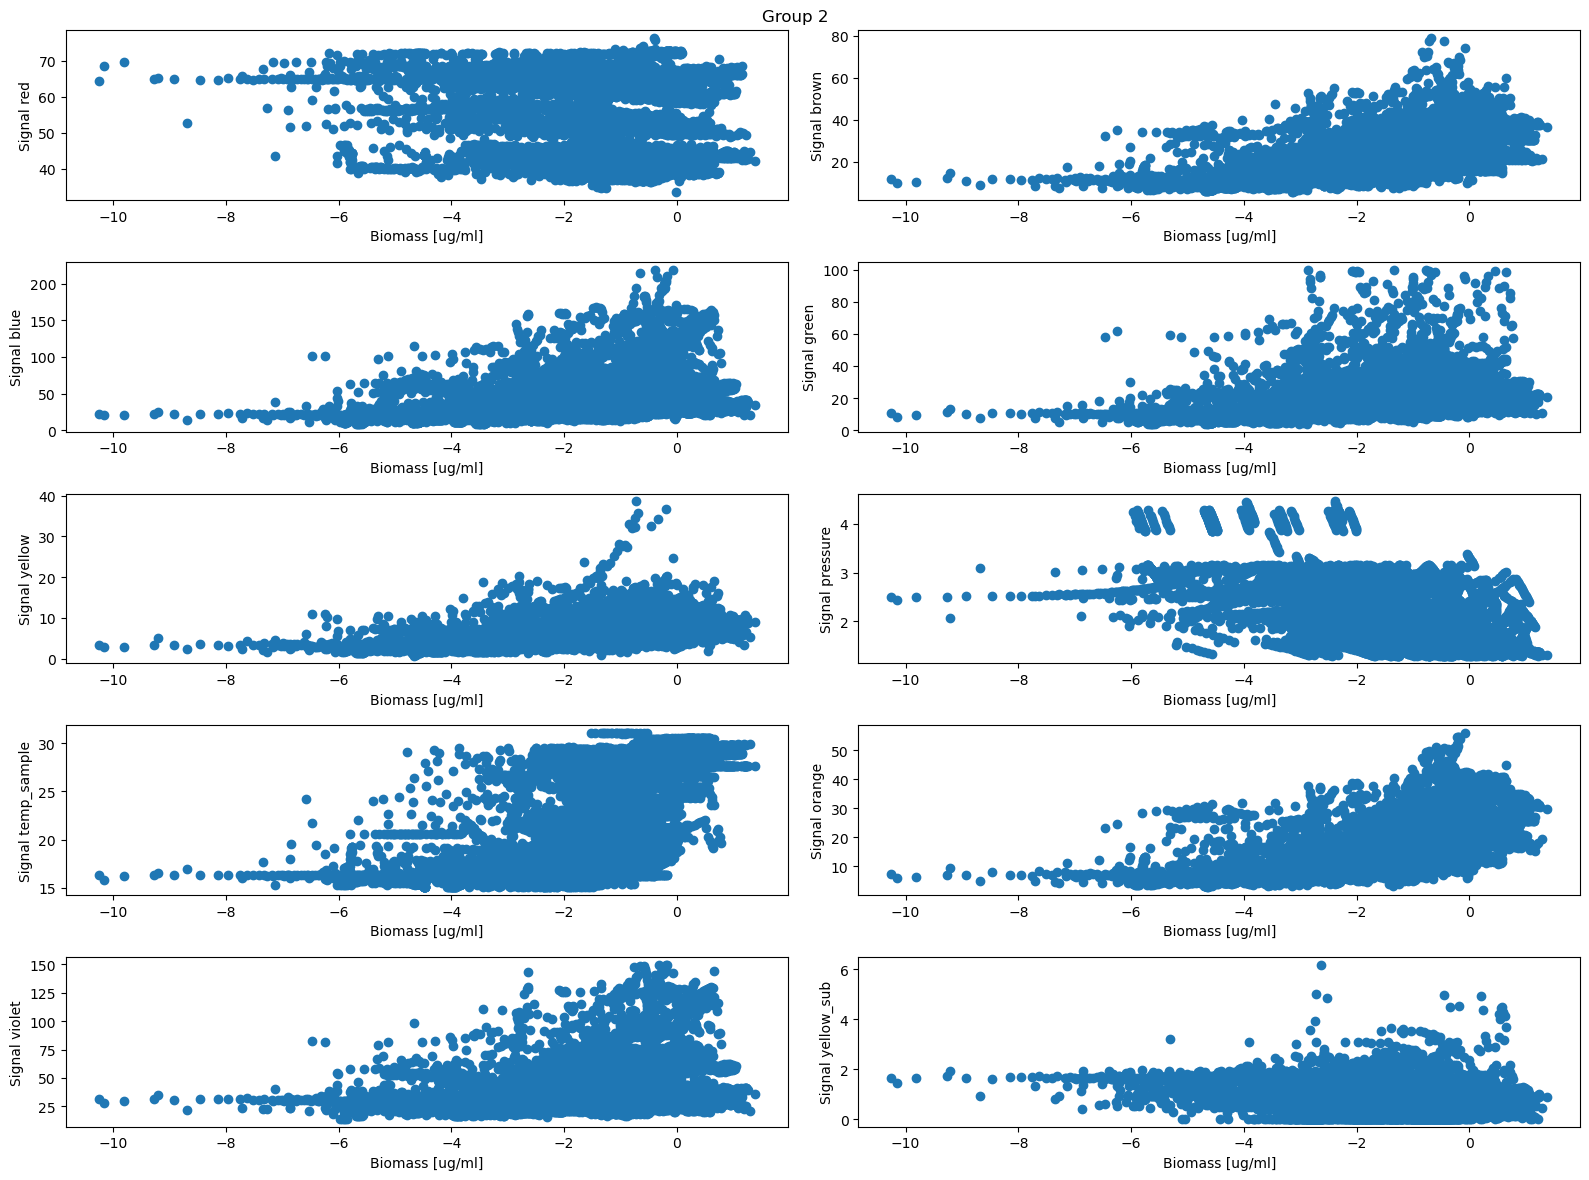

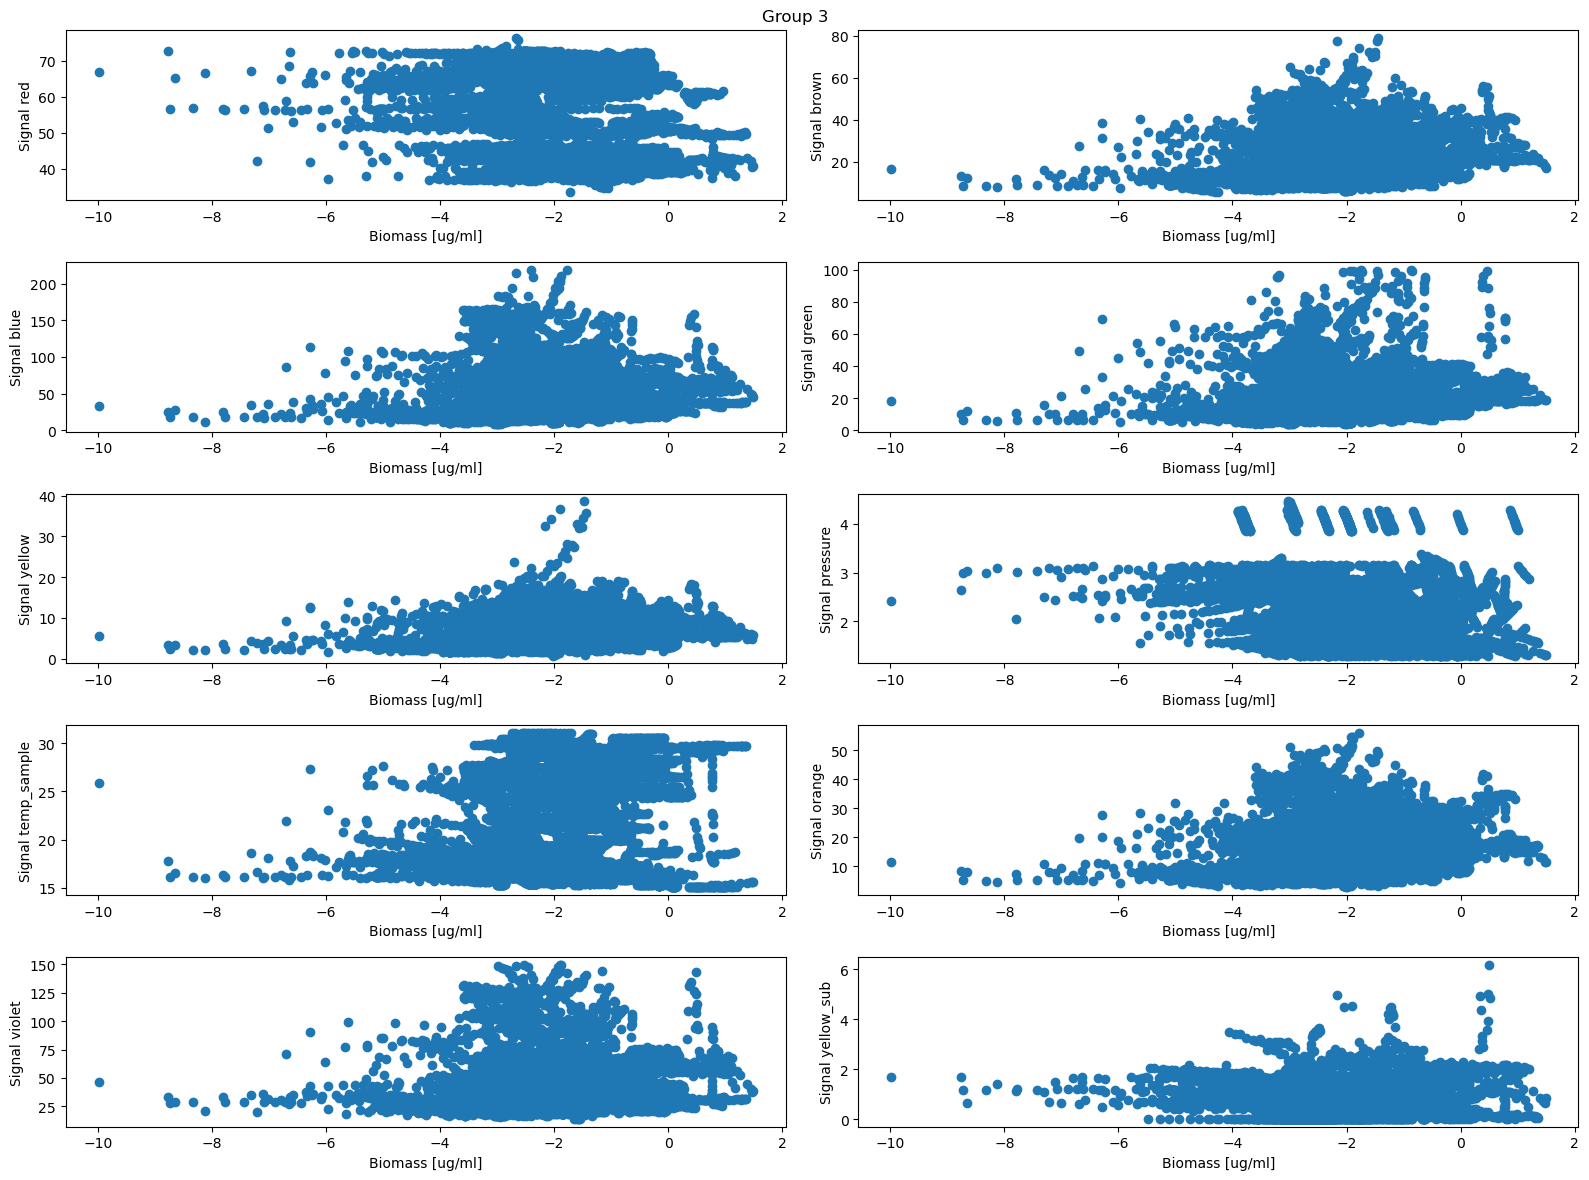

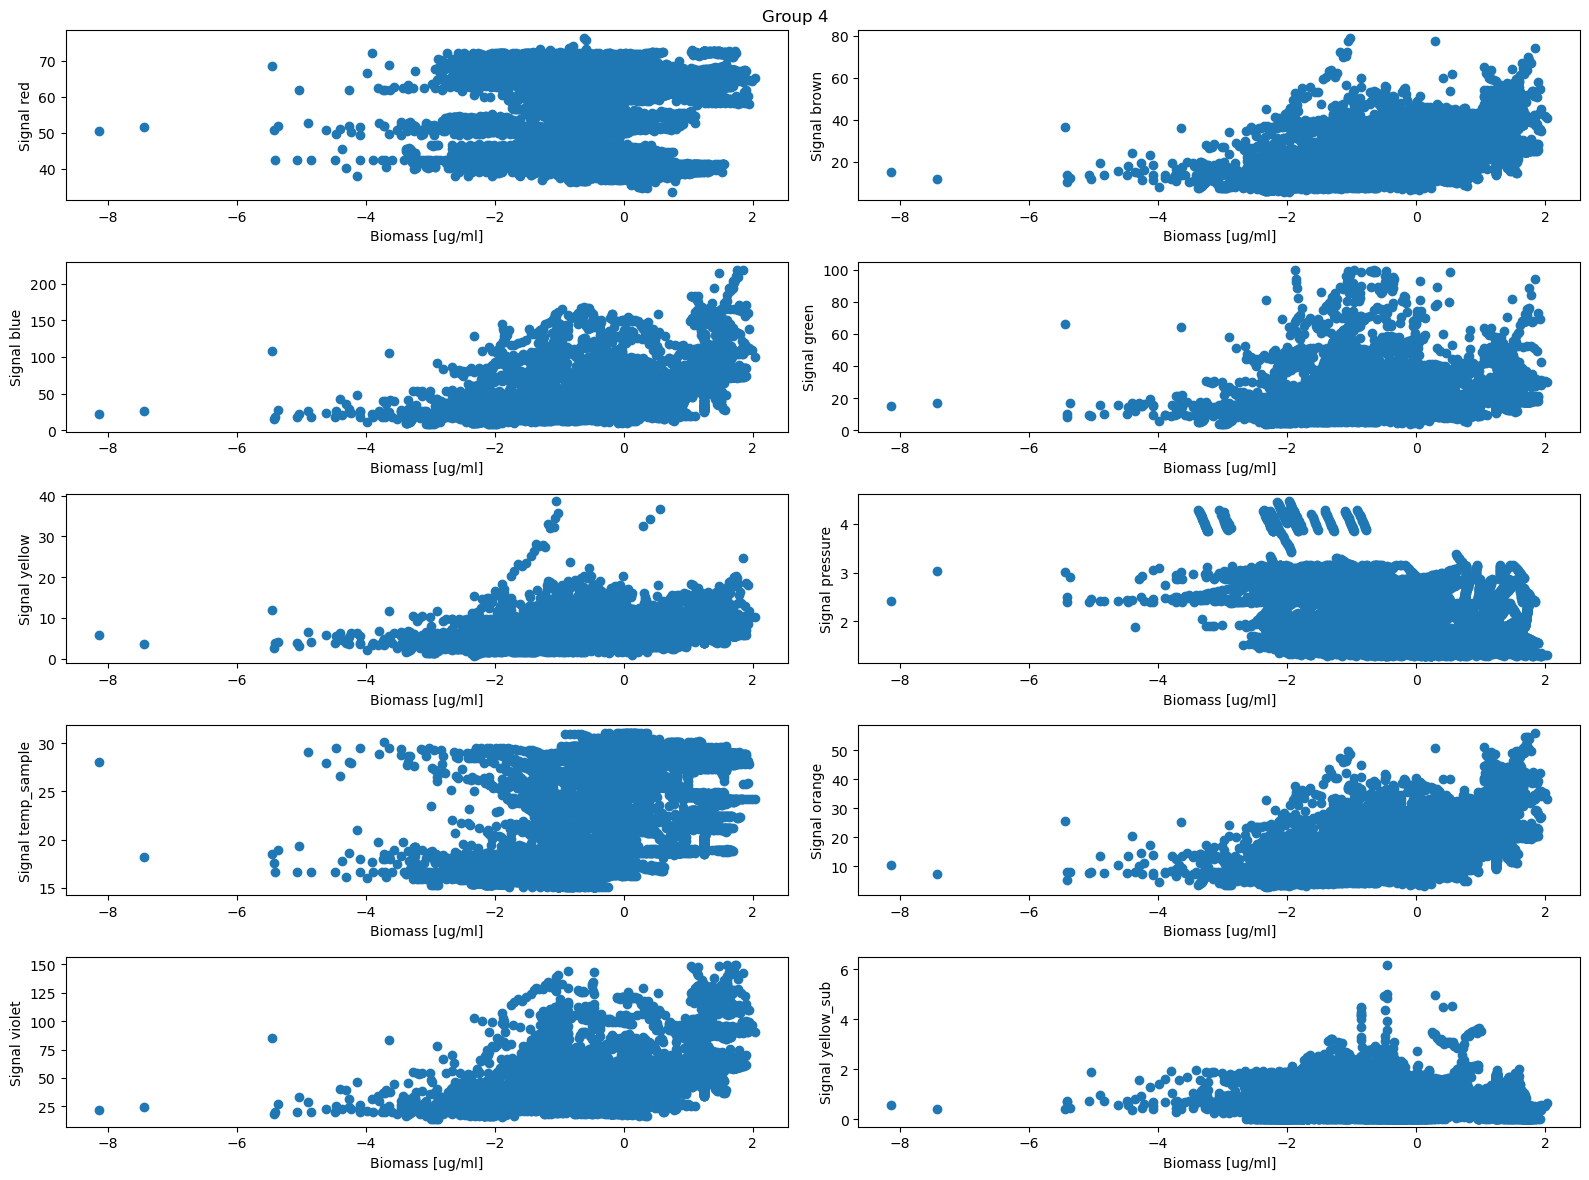

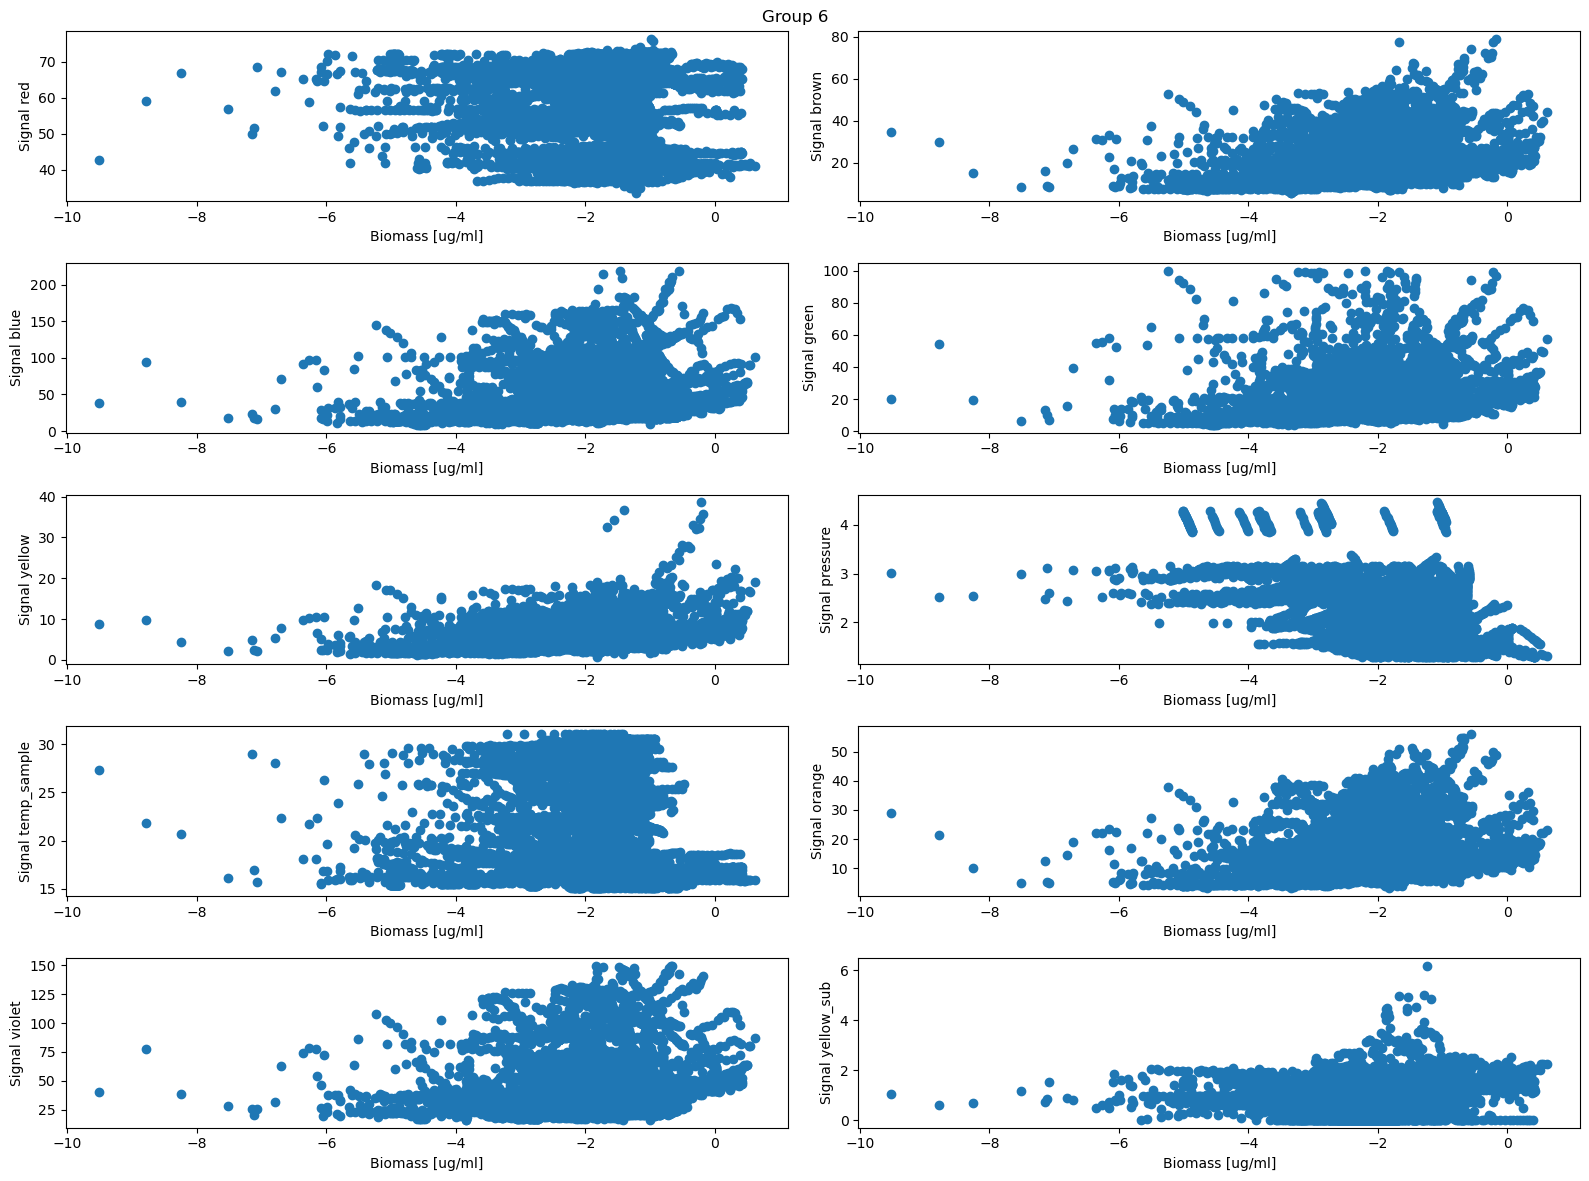

In [29]:
plot_corr_per_feature_per_group(merged_train, fluor_groups_map)

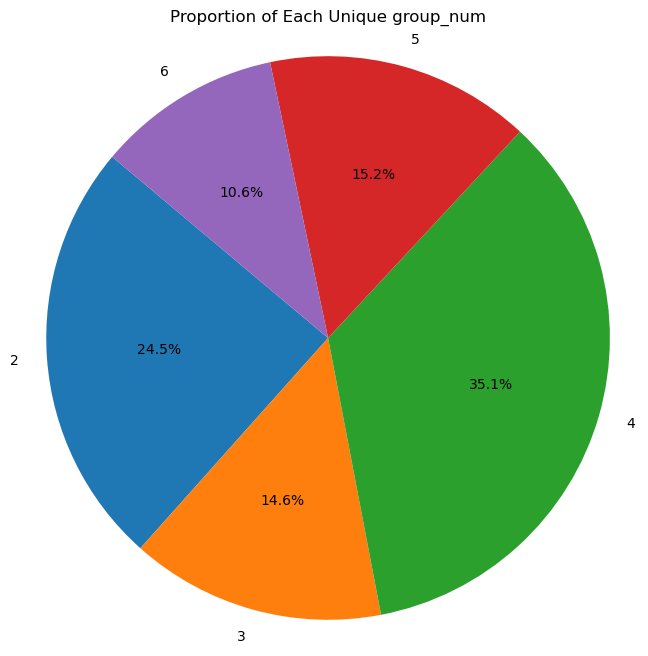

In [67]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.exp)
groups_pie_chart(merged_train, by_biomass=True)

In [34]:
merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
merged_test = merged_test.drop(['year', 'Depth', 'week', 'depth_discrete', 'month'], axis=1)

# Training models and evaluating

In [36]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

def two_scorer(mse=False):
    score = mean_squared_error if mse else r2_score
    return make_scorer(score, greater_is_better=mse==False)

In [37]:
if do_search:
#     param_grid_per_model = {'xgb': {
#         "model__n_estimators": [100, 300, 500], # Number of boosting rounds
#         "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
#         "model__max_depth": [3, 5, 7, 11], # Maximum depth of a tree,
#         'model__min_child_weight': [1, 5, 7],  # Minimum sum of instance weight needed in a child
#         "model__subsample": [0.2, 0.5, 1.0], # Fraction of samples used for fitting trees
#         "model__colsample_bytree": [0.2, 0.8, 1.0] # Fraction of features used for fitting trees
#     },
#     'svr':  {
#         "model__C": [0.1, 1, 10, 100], # Regularization parameter
#         "model__kernel": ["poly", "rbf"],
#         "model__degree": [1, 2, 3], # Degree of the polynomial kernel (for "poly" kernel)
#         "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
#         "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
#     },
#     'elf': {
#         "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
#         "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
#         "model__fit_intercept": [True, False], # Whether to calculate the intercept for the model
#     }}
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 500], # Number of boosting rounds
        "model__max_depth": [2, 3, 5], # Maximum depth of a tree,
        "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
        "model__alpha": [0.01, 0.1, 1, 10], # L1 regularization term
        "model__lambda": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    },
    'svr':  {
        "model__C": [0.001, 0.1, 1, 10, 100], # Regularization parameter
        "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_train, param_grid=param_grid,
                                                                scoring_method=two_scorer(mse=False))
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

In [38]:
regularized_kwargs = {}
param_per_model = {'xgb': {
    "max_depth": 5, # Maximum depth of a tree,
    "alpha": 10, # L1 regularization term
    "lambda": 0.5, # Mixing parameter between L1 and L2 regularization
},
'svr':  {
    "C": 10000, # Regularization parameter
    "tol": 1e-3 # Tolerance for stopping criterion
},
'elf': {
    "alpha": 10, # Regularization parameter
    "l1_ratio": 0.0, # Mixing parameter between L1 and L2 regularization
}}
for model_name in best_group_params_per_model_fixed.keys():
    regularized_kwargs[model_name] = {}
    for group_num in best_group_params_per_model_fixed[model_name].keys():
        regularized_kwargs[model_name][group_num] = param_per_model[model_name]

In [86]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train('xgb', merged_train, group_kwargs=regularized_kwargs, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models['lr'], _ = train('lr', merged_train, test_size=0.0, biomass_fn=np.log)

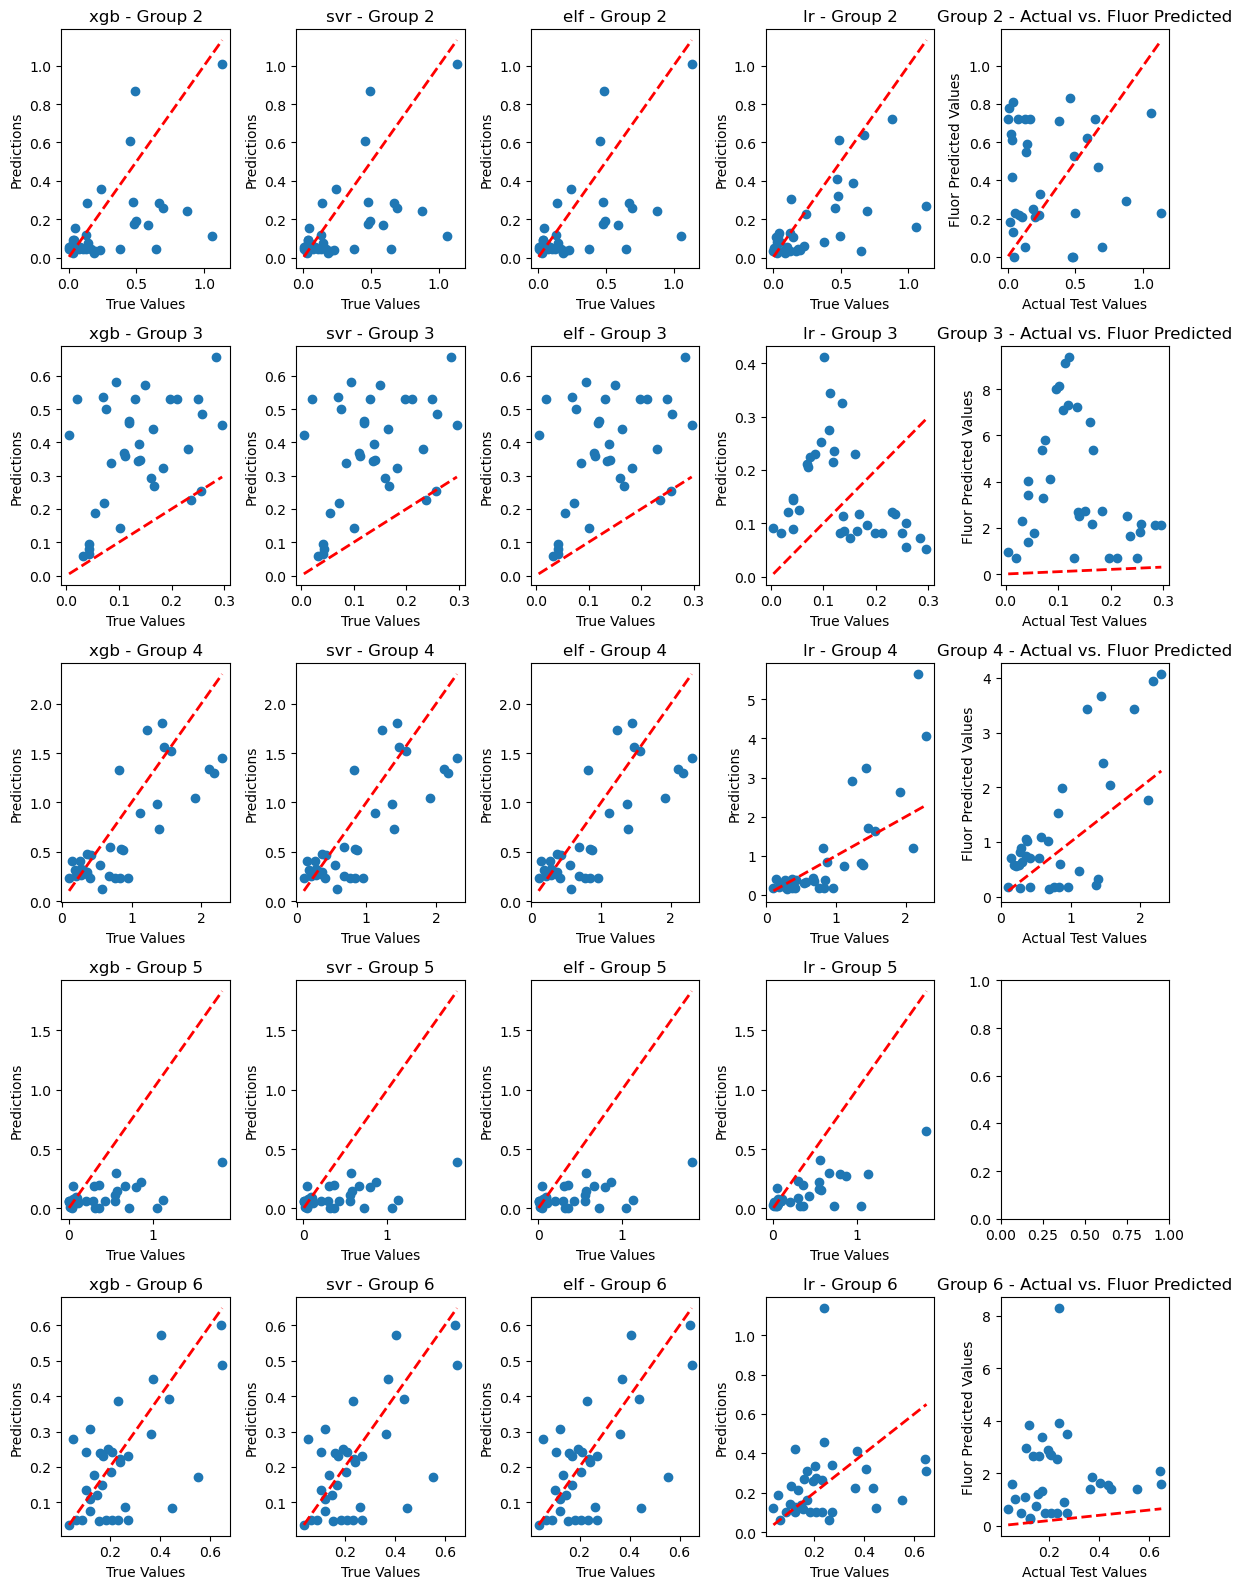

In [87]:
comparing_df = compare_all_models(regression_models, merged_test, fluor_test_df, fluor_groups_map, predictions_fn=np.exp)

In [88]:
comparing_df

,Group,Model,RMSE,R-squared
0,2,xgb,0.285829,0.130681
1,2,svr,0.285829,0.130681
2,2,elf,0.285829,0.130681
3,2,lr,0.276578,0.186043
4,2,FP,0.435020,-1.013651
5,3,xgb,0.276910,-11.326462
6,3,svr,0.276910,-11.326462
7,3,elf,0.276910,-11.326462
8,3,lr,0.139197,-2.114733
9,3,FP,4.442027,-3170.919561
